## Implementation of Variational Autoencoder for Image Attribute Manipulation with CelebA

### Libraries

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from mpl_toolkits.axes_grid1 import ImageGrid

### Tranformations

In [2]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### Selected attributes

In [3]:
SELECTED_ATTRS = ["Eyeglasses", "Wearing_Hat", "Bangs", "Wavy_Hair", "Pointy_Nose", "Mustache", "Oval_Face", "Smiling"]


### Dataset class

In [4]:
class FilteredCelebA(Dataset):
    def __init__(self, root, split='train', transform=None):
        self.dataset = CelebA(root=root, split=split, download=False, transform=transform)
        SELECTED_ATTRS = ["Eyeglasses", "Wearing_Hat", "Bangs", "Wavy_Hair", "Pointy_Nose", "Mustache", "Oval_Face", "Smiling"]
        self.attr_indices = [self.dataset.attr_names.index(attr) for attr in SELECTED_ATTRS]
        self.filtered_indices = []
        for i in range(len(self.dataset)):
            attrs = self.dataset.attr[i][self.attr_indices]
            if any(attrs):  # Keep image if any selected attribute is present
                self.filtered_indices.append(i)

    def __len__(self):
        return len(self.filtered_indices)

    def __getitem__(self, index):
        real_index = self.filtered_indices[index]
        img, attrs = self.dataset[real_index]
        filtered_attrs = attrs[self.attr_indices]
        return img, filtered_attrs


In [5]:
dataset = FilteredCelebA(root="../data", split='train', transform=transform)

### Data loader

In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers = 1, pin_memory = True,  shuffle=True, persistent_workers=True)

In [7]:
EPOCHS = 20
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
Z = 64
KLD_WEIGHT = 0.0012

# 1. Implementation of a conditional VAE (cVAE) that can manipulate image attributes.


In [ ]:
class Encoder(nn.Module):
    """Encoder part of the VAE"""
    def __init__(self, z, num_classes):
        super(Encoder, self).__init__()
        self.num_classes = num_classes
        self.encoder_top = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
        )
        
        self.mu_layer = nn.Linear(512 + num_classes, z)
        self.logvar_layer = nn.Linear(512 + num_classes, z)

    def forward(self, x, labels):
        x = self.encoder_top(x)
        x = torch.cat([x, labels], dim=1)
        # The mean of the latent space distribution
        mu = self.mu_layer(x)
        # Logarithm of the variance
        logvar = self.logvar_layer(x)
        return mu, logvar

class Decoder(nn.Module):
    """Decoder part of the VAE"""
    def __init__(self, z, num_classes, selected_attrs_len):
        super(Decoder, self).__init__()
        self.condition_layer = nn.Linear(selected_attrs_len, 128)
        self.decoder = nn.Sequential(
            nn.Linear(z + 128, 1024 * 2 * 2),
            nn.BatchNorm1d(1024 * 2 * 2),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (1024, 2, 2)),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z, labels):
        labels = labels.float()
        labels = F.leaky_relu(self.condition_layer(labels))
        z = torch.cat([z, labels], dim=1)
        x = self.decoder(z)
        return x

class VariationalAutoEncoder(nn.Module):
    """Combines Encoder and Decoder to form VAE"""
    def __init__(self, z, num_classes, selected_attrs_len):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = Encoder(z, num_classes)
        self.decoder = Decoder(z, num_classes, selected_attrs_len)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x, labels):
        mu, logvar = self.encoder(x, labels)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z, labels)
        return recon_x, mu, logvar

# Example usage
device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = 8 
selected_attrs_len = 8  
model = VariationalAutoEncoder(z=Z, num_classes=num_classes, selected_attrs_len=selected_attrs_len)
model.to(device)

VariationalAutoEncoder(
  (encoder): Encoder(
    (encoder_top): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01)
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.01)
      (12): Flatten(start_dim=1, end_dim=-1)
      (13): Linear(in_features=2048

### Loading the state dictionary

In [ ]:

model_path = 'model_VAE_forGANS_classes_moreComplex.pth'

state_dict = torch.load(model_path)
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith("module."):
        new_key = key[len("module."):]  
    else:
        new_key = key
    new_state_dict[new_key] = value

model.load_state_dict(new_state_dict)

<All keys matched successfully>

# 2. Training the VAE on the CelebA dataset.


In [ ]:
def loss_fn(y_true, y_pred, mu, logvar):

  reconstruction_loss = nn.functional.mse_loss(y_pred, y_true)

  kld_loss =   torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)

  loss = (1-KLD_WEIGHT)*reconstruction_loss + KLD_WEIGHT*kld_loss
  return loss

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:

for i in range(1, EPOCHS + 1):
    running_loss = 0
    pbar = tqdm(dataloader)
    for b, data in enumerate(pbar):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs, mu, logvar = model(inputs, labels)

        loss = loss_fn(inputs, outputs, mu, logvar)
        loss.backward()

        optimizer.step()
        
        running_loss += loss.item()
        pbar.set_description(f"Epoch {i}/{EPOCHS}: ")
        pbar.set_postfix({"batch_loss": loss.item(), "avg_loss": running_loss / (b + 1)})

Epoch 20/20: : 100%|██████████| 271/271 [01:30<00:00,  3.00it/s, batch_loss=0.0949, avg_loss=0.0939]


In [16]:
model.cpu()

torch.save(model.state_dict(), 'model_VAE_forGANS_classes_moreComplex.pth')
model.to(device)


DataParallel(
  (module): VariationalAutoEncoder(
    (encoder): Encoder(
      (encoder_top): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.01)
        (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): LeakyReLU(negative_slope=0.01)
        (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (11): LeakyReLU(negative_slope=0.01)
        (12): Flatten(star

# 3. Results


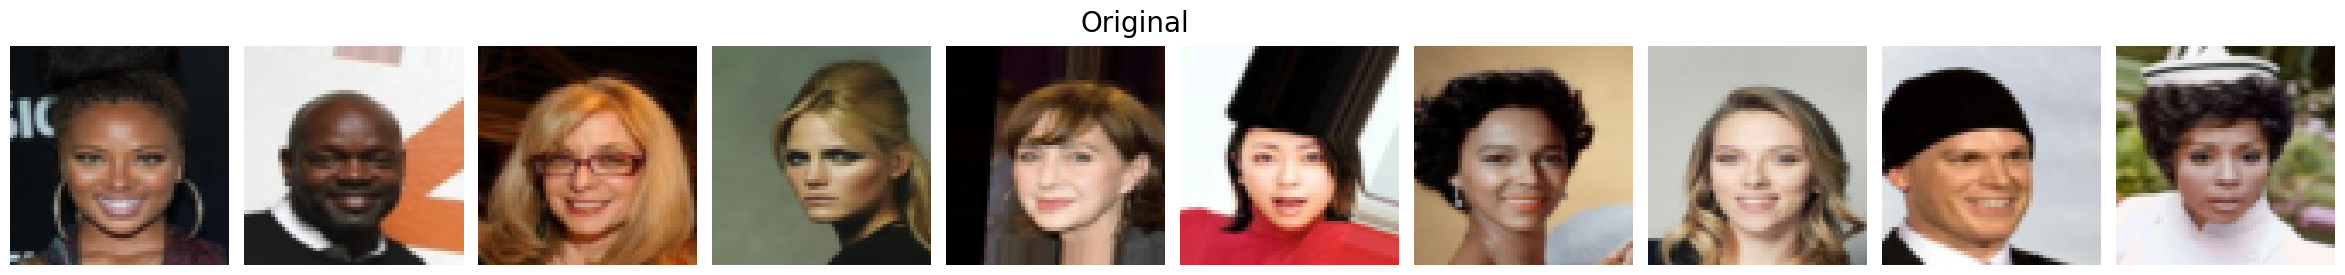

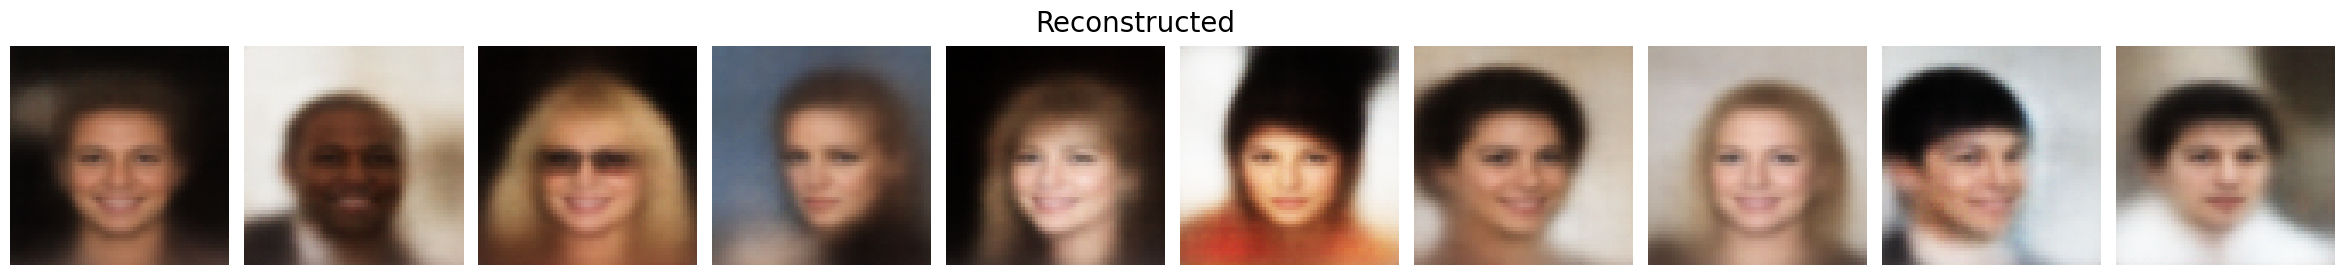

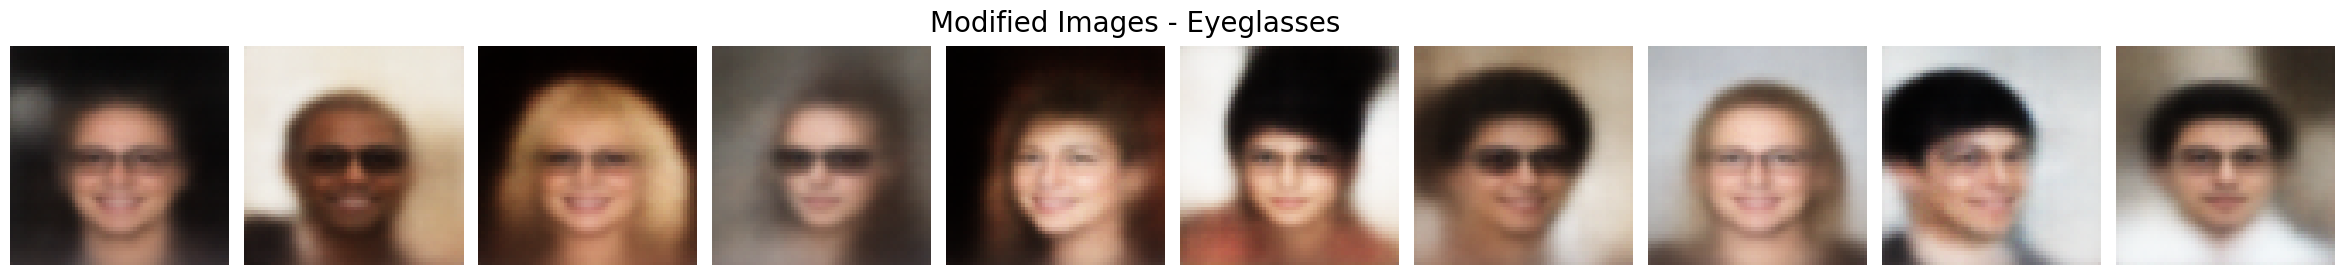

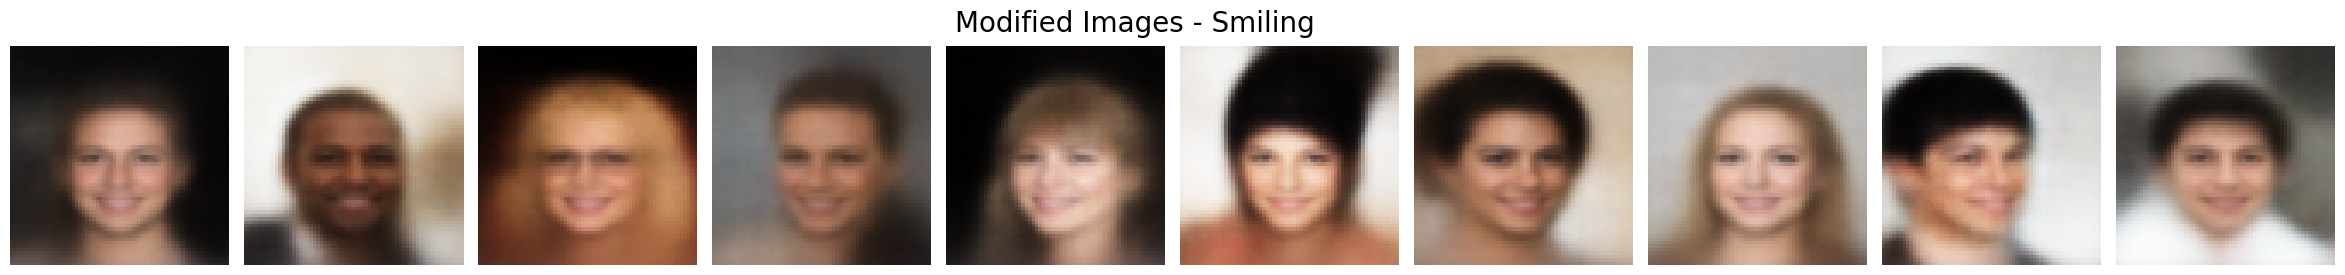

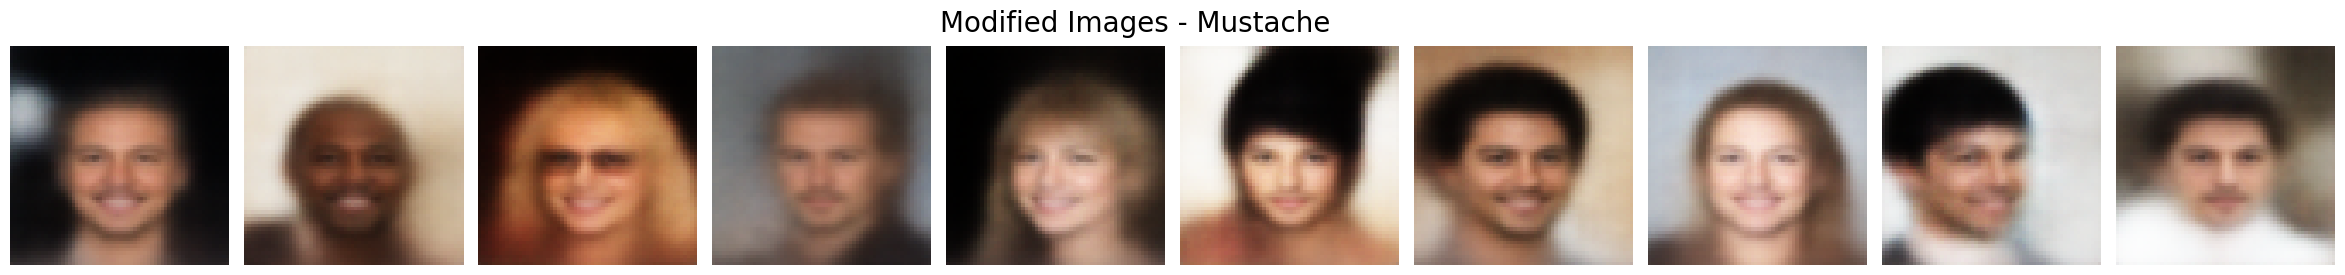

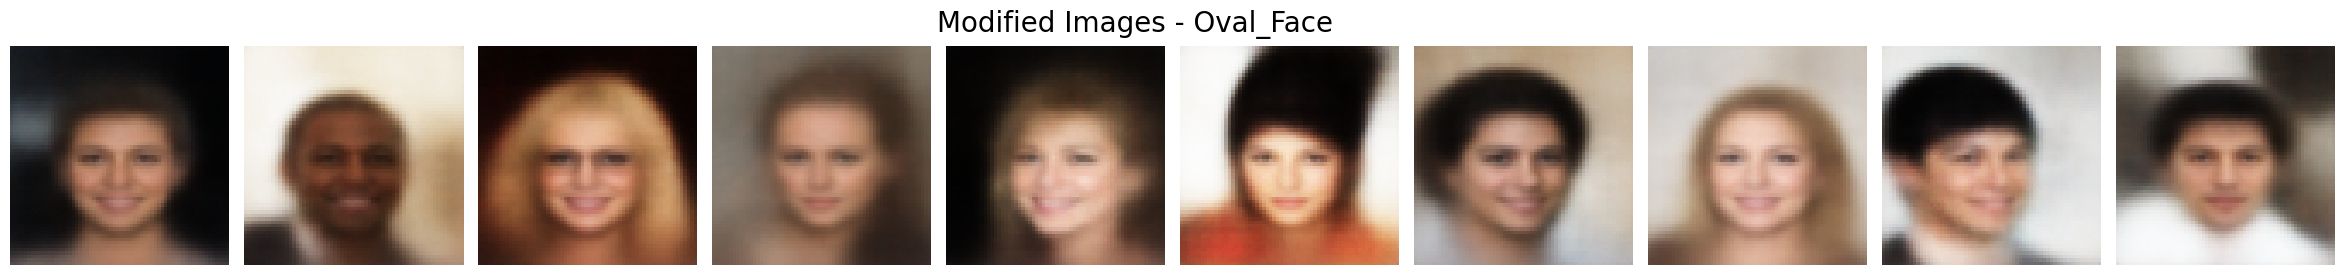

In [ ]:
def change_attribute(image, label, model, device, attribute_index):
    label = label.unsqueeze(0).to(device)
    image = image.unsqueeze(0).to(device)

    modified_label = label.clone()
    modified_label[:, attribute_index] = 1 
    model.eval()

    with torch.no_grad():
        modified_image = model(image, modified_label)[0].cpu()

    return modified_image.squeeze(0)  


def display_image_grid(images, num_rows, num_cols, title_text):
    fig = plt.figure(figsize=(num_cols * 3., num_rows * 3.))
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        if im.dim() == 2:  
            im = im.unsqueeze(0)
        im = im.permute(1, 2, 0)  
        im = im * 0.5 + 0.5 
        ax.imshow(im.detach().cpu().numpy())  
        ax.axis("off")

    plt.suptitle(title_text, fontsize=20)
    plt.show()


def no_change_attribute(image, label, model, device):
    label = label.unsqueeze(0).to(device)
    image = image.unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        reconstructed_image = model(image, label)[0].cpu()

    return reconstructed_image.squeeze(0)


attribute_indices = {
    "Eyeglasses": SELECTED_ATTRS.index("Eyeglasses"),
    "Smiling": SELECTED_ATTRS.index("Smiling"),
    "Mustache": SELECTED_ATTRS.index("Mustache"),
    "Oval_Face": SELECTED_ATTRS.index("Oval_Face"),
    "Smiling": SELECTED_ATTRS.index("Smiling")
}

num_samples = 10
sample_indices = torch.randint(len(dataset), size=(num_samples,))

first = True

for attribute, index in attribute_indices.items():
    original_images = []
    modified_images = []
    reconstructed_images = []
    for sample_idx in sample_indices:
        img, label = dataset[sample_idx]
        
        original_images.append(img)
        modified_img = change_attribute(img, label, model, device, index)
        modified_images.append(modified_img)
        if first:
            reconstructed_image = no_change_attribute(img, label, model, device)
            reconstructed_images.append(reconstructed_image)
    
    if first:
        display_image_grid(original_images, 1, num_samples, f"Original" )
        display_image_grid(reconstructed_images, 1, num_samples, f"Reconstructed" )
        first = False
        

    display_image_grid(modified_images, 1, num_samples, f"Modified Images - {attribute}")
    
